In [9]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}, GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")

# import sys
# print(sys.executable)

SEED = 42
BATCH_SIZE = 64

H, W = 48, 48
IMG_SIZE = (48, 48)

TensorFlow version: 2.10.1, GPU: True


In [11]:
import os
from tensorflow.keras import layers

DATA_DIR = os.path.join(os.getcwd(), 'data', 'Emotions_dataset')

training_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="training", seed=SEED, image_size=IMG_SIZE,
    color_mode="grayscale", batch_size=BATCH_SIZE, label_mode="int")

validation_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="validation", seed=SEED, image_size=IMG_SIZE,
    color_mode="grayscale", batch_size=BATCH_SIZE, label_mode="int")

CLASS_NAMES = validation_ds.class_names
NUM_CLASSES = len(validation_ds.class_names)
print(f"Number of classes is {NUM_CLASSES} and classes are {CLASS_NAMES}")

data_augmentation = tf.keras.Sequential([layers.Rescaling(1. / 255),
                                         layers.RandomFlip("horizontal"),
                                         layers.RandomRotation(0.05),
                                         layers.RandomZoom(0.1)])

rescale_only = tf.keras.Sequential([layers.Rescaling(1. / 255)])

AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.shuffle(1000)
training_ds = training_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
training_ds = training_ds.prefetch(AUTOTUNE)

validation_ds = training_ds.map(lambda x, y: (rescale_only(x), y), num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(AUTOTUNE)

for i, (images, labels) in enumerate(training_ds.take(1)):
    print(f"training_ds Batch {i + 1}  image shape {images.shape} and labels shape {labels.shape}")

Found 35887 files belonging to 7 classes.
Using 28710 files for training.
Found 35887 files belonging to 7 classes.
Using 7177 files for validation.
Number of classes is 7 and classes are ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
training_ds Batch 1  image shape (64, 48, 48, 1) and labels shape (64,)


In [12]:
# class imbalance handling
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = np.concatenate([y.numpy() for _, y in training_ds])

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.0385992837246318, 1: 9.300291545189504, 2: 1.0008366450533361, 3: 0.572505384063173, 4: 0.8270676691729323, 5: 0.8421824581988853, 6: 1.2701853736229705}


In [13]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ELU, Input, Conv2D, MaxPool2D, BatchNormalization, Activation, Flatten, Dropout, \
    Dense

model = Sequential()

# Block #1: first CONV => RELU => CONV => RELU => POOL
model.add(Input(shape=(48, 48, 1)))
# model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(BatchNormalization(axis=-1))  # default is axis= -1
model.add(ELU())

model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())

model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())

model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
model.add(BatchNormalization())
model.add(ELU())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(tf.keras.layers.GlobalAveragePooling2D())

# Block #6: second set of FC => RELU layers
model.add(Dense(256, kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(ELU())

model.add(Dropout(0.4))

# Block #7: softmax classifier
model.add(Dense(NUM_CLASSES, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 elu_1 (ELU)                 (None, 48, 48, 32)       

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=10000)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# callbacks = [ModelCheckpoint("emotion_model.keras", save_best_only=True), CSVLogger("training_log.csv")]

history = model.fit(training_ds, validation_data=validation_ds, epochs=10,
                    # callbacks=callbacks,
                    class_weight=class_weights, verbose=1)


Epoch 1/10
449/449 [==============================] - 33s 41ms/step - loss: 2.1490 - accuracy: 0.1757 - val_loss: 1.9045 - val_accuracy: 0.2495
Epoch 2/10
449/449 [==============================] - 15s 27ms/step - loss: 1.9507 - accuracy: 0.2186 - val_loss: 2.4237 - val_accuracy: 0.1727
Epoch 3/10
449/449 [==============================] - 15s 27ms/step - loss: 1.7952 - accuracy: 0.2855 - val_loss: 2.1315 - val_accuracy: 0.1727
Epoch 4/10
449/449 [==============================] - 14s 26ms/step - loss: 1.6816 - accuracy: 0.3362 - val_loss: 2.7055 - val_accuracy: 0.1696
Epoch 5/10
449/449 [==============================] - 15s 27ms/step - loss: 1.6069 - accuracy: 0.3769 - val_loss: 2.2105 - val_accuracy: 0.1696
Epoch 6/10
449/449 [==============================] - 15s 27ms/step - loss: 1.5473 - accuracy: 0.3986 - val_loss: 2.4150 - val_accuracy: 0.1728
Epoch 7/10
449/449 [==============================] - 15s 27ms/step - loss: 1.5061 - accuracy: 0.4127 - val_loss: 2.6335 - val_accuracy:

# Evaluation Metric

449/449 [==============================] - 3s 6ms/step - loss: 2.5770 - accuracy: 0.1696
Accuracy: 16.96%


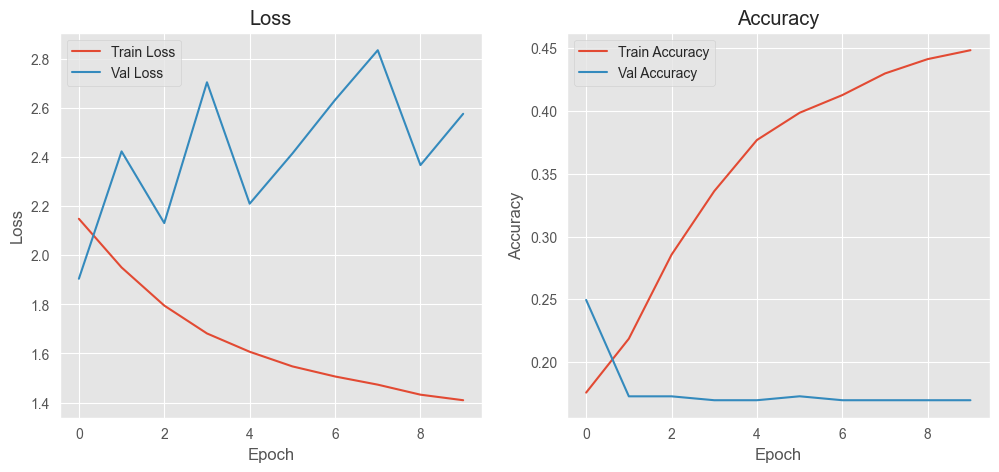

In [18]:
# model.save("data\model.keras")
# model.save("model", save_format="tf")
# model.save('model.h5')

loss, acc = model.evaluate(validation_ds)
print(f"Accuracy: {acc * 100:.2f}%")

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      3949
     disgust       0.00      0.00      0.00       441
        fear       0.00      0.00      0.00      4098
       happy       0.00      0.00      0.00      7164
     neutral       0.00      0.00      0.00      4959
         sad       0.17      1.00      0.29      4870
    surprise       0.00      0.00      0.00      3229

    accuracy                           0.17     28710
   macro avg       0.02      0.14      0.04     28710
weighted avg       0.03      0.17      0.05     28710

Confusion Matrix:
 [[   0    0    0    0    0 3949    0]
 [   0    0    0    0    0  441    0]
 [   0    0    0    0    0 4098    0]
 [   0    0    0    0    0 7164    0]
 [   0    0    0    0    0 4959    0]
 [   0    0    0    0    0 4870    0]
 [   0    0    0    0    0 3229    0]]


C:\Users\zabeeh\anaconda3\envs\v_tf_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zabeeh\anaconda3\envs\v_tf_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zabeeh\anaconda3\envs\v_tf_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

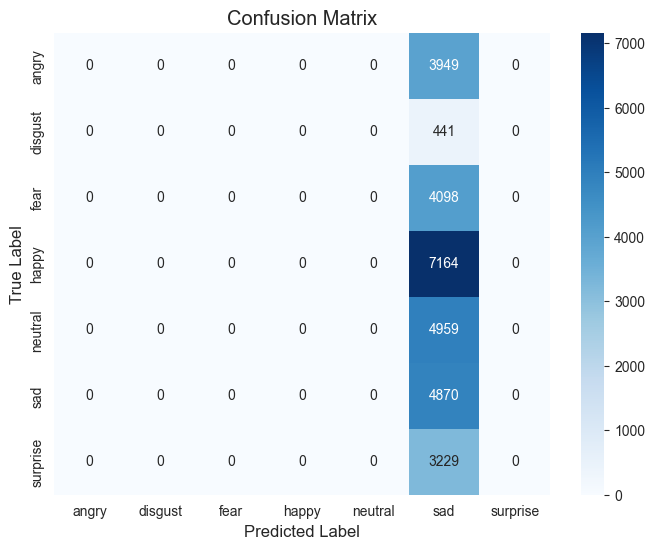

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = []
y_true = []

for images, labels in validation_ds:
    preds = model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)

    y_pred.extend(preds)
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()